In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from scipy import stats
#from scikit_posthocs import posthoc_dunn
from scipy.stats import f_oneway
from scipy.stats import kruskal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
#import shap
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change features' names
result = pd.read_csv('/content/drive/MyDrive/Stress/SHAP.csv')
remove_list = ['doryab_','intraday_','rapids_','phone_','fitbit_']
for r in remove_list:
    result.columns = [col.replace(r, '') for col in result.columns]

In [3]:
result = result[result['AUC']>0.5]
result.shape

(60, 67)

In [4]:
# add sample_size to dataframe
data = pd.read_csv('/content/drive/MyDrive/Stress/data.csv')
for i, pid_value in enumerate(data.pid.unique()):
  if pid_value in result.pid.unique():
      pid = data[data.pid == pid_value]
      result_pid = result[result.pid == int(pid_value[1:])]
      result.loc[i,'sample_size'] = pid.shape[0]
      result.loc[i,'label1_size'] = (pid[pid['label']==1].shape[0]/pid.shape[0])*100

In [5]:
demo = pd.read_csv('/content/drive/MyDrive/Stress/demographics.csv')
demo['participantID'] = demo['participantID'].apply(lambda x: 'p' + str(x))
demo.columns = demo.columns.str.replace(' ', '_')

In [6]:
def get_ethnicity(row):
    if row['White'] == 1:
        return 0
    elif row['Asian'] == 1:
        return 1
    elif row['Other'] == 1:
        return 2
    else:
        return 2  # Handle the case when none of the values are 1

demo['Races'] = demo.apply(get_ethnicity, axis=1)
demo.drop(['White', 'Asian', 'Other'], axis=1, inplace=True)

In [7]:
# merge together
result.rename(columns = {'pid':'participantID'}, inplace = True)
demo = pd.merge(result[['participantID']],demo,on='participantID', how='left')

In [8]:
# class size overview
data = pd.read_csv('/content/drive/MyDrive/Stress/data.csv')
print(data[data['label']==0].shape[0])
print(data[data['label']==1].shape[0])

29726
1650


In [9]:
# performance for classifying the stress class
print(np.mean(result['F1']), np.std(result['F1']))
print(np.mean(result['Recall']), np.std(result['Recall']))
print(np.mean(result['Precision']), np.std(result['Precision']))
print(np.mean(result['AUC']), np.std(result['AUC']))

0.24814701603333333 0.1742959101796607
0.20731894894999997 0.16764398491424107
0.3348995441666667 0.20181128928891062
0.7492140272833333 0.09871127203964522


In [10]:
demos = ['Gender', 'Races','education', 'maritalStatus', 'degree','currentEmployment','mentalHealth',
        'Depression', 'Anxiety','eatingDisorder', 'familyProblems','physicalHandicap']
full_df = pd.merge(demo, result, how='inner', on='participantID')

In [11]:
np.mean(full_df[full_df['maritalStatus']==4]['label1_size'])

6.2244824395371365

In [12]:
np.mean(full_df[full_df['maritalStatus']==4]['AUC'])

0.7489192829302325

In [13]:
base_color = [173/255, 216/255, 230/255,255/255]  # This is light blue

Gender
               sum_sq    df         F    PR(>F)
C(Gender)    0.039850   1.0  4.170310  0.045775
label1_size  0.001028   1.0  0.107599  0.744097
Residual     0.544677  57.0       NaN       NaN
ANCOVA result for Gender: p = 0.04577467115208289
AUC scores differ significantly across groups in Gender (p=0.04577467115208289).
Races
               sum_sq    df         F    PR(>F)
C(Races)     0.069880   2.0  3.801919  0.028296
label1_size  0.000088   1.0  0.009533  0.922570
Residual     0.514648  56.0       NaN       NaN
ANCOVA result for Races: p = 0.02829644361201111
AUC scores differ significantly across groups in Races (p=0.02829644361201111).
education
                    sum_sq    df         F    PR(>F)
C(education)  8.325883e-03   3.0  0.262593  0.852033
label1_size   9.002646e-07   1.0  0.000085  0.992670
Residual      5.707165e-01  54.0       NaN       NaN
ANCOVA result for education: p = 0.8520331628968669
maritalStatus
                    sum_sq    df         F    PR(>F)
C(

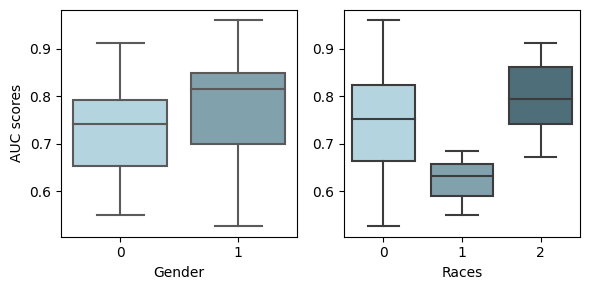

In [14]:
significant_auc_demos = []
alpha = 0.05

for demo_feature in demos:
    print(demo_feature)
    df_filtered = full_df[[demo_feature, 'AUC', 'label1_size']]

    model = ols('AUC ~ C(' + demo_feature + ') + label1_size', df_filtered).fit()

    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    p_val = anova_table.loc['C(' + demo_feature + ')', 'PR(>F)']
    print(f"ANCOVA result for {demo_feature}: p = {p_val}")

    if p_val < alpha:
        print(f"AUC scores differ significantly across groups in {demo_feature} (p={p_val}).")
        significant_auc_demos.append(demo_feature)


max_boxes = max(full_df[demo_feature].nunique() for demo_feature in significant_auc_demos)

# Generating a list of shades of blue for all boxes
colors = [[max(0, base_color[0]-i*0.2), max(0, base_color[1]-i*0.2), max(0, base_color[2]-i*0.2)] for i in range(max_boxes)]

fig, axes = plt.subplots(1, len(significant_auc_demos), figsize=(6, 3))
if len(significant_auc_demos) == 1:
    axes = [axes]  # To make sure axes is always a list
else:
    axes = axes.ravel()

for idx, demo_feature in enumerate(significant_auc_demos):

    df_filtered = full_df[[demo_feature, 'AUC']]

    ax = sns.boxplot(x=demo_feature, y='AUC', data=df_filtered, ax=axes[idx], palette=colors)

    # You can uncomment the following line if you want titles for each boxplot.
    # axes[idx].set_title('Boxplot of AUC scores across ' + demo_feature + ' groups')

    # axes[idx].set_xlabel(demo_feature)
    if idx == 0:
        axes[idx].set_ylabel('AUC scores')
    else:
        axes[idx].set_ylabel('')

plt.tight_layout()
plt.savefig('group.pdf')
plt.show()